In [1]:
import csv
import numpy as np

from joblib import parallel_backend
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

This notbook will try different methods for clustering subcluster modules.
 I will use a small test set generated from mibig4.

In [56]:
def string_to_tokenized_genes(genes_string):
    return [tuple(gene.split(";")) for gene in genes_string.split(",")]


class StatModule:
    def __init__(
        self,
        module_id,
        strictest_pval,
        tokenised_genes,
    ):
        self.module_id = module_id
        self.n_genes = len(tokenised_genes)
        self.n_domains = sum(len(gene) for gene in tokenised_genes)
        self.tokenised_genes = tokenised_genes
        self.strictest_pval = strictest_pval

    def __repr__(self):
        return (
            f"StatModule("
            f"module_id={self.module_id}, "
            f"strictest_pval={self.strictest_pval}, "
            f"n_genes={self.n_genes}, "
            f"n_domains={self.n_domains}, "
            f"tokenised_genes={self.tokenised_genes})"
        )


def read_stat_modules(file_path):
    """
    Reads statistical modules from a tab-separated file into a list of StatModules.

    Parameters:
        file_path (str): The file path to the input file.

    Returns:
        dict: A dictionary where keys are module IDs and values are StatModule objects.
    """
    with open(file_path, "r", newline="") as infile:
        reader = csv.DictReader(infile, delimiter="\t")
        modules = {}
        for row in reader:
            module_id = "M" + row["module_id"]
            strictest_pval = float(row["strictest_pval"])
            tokenised_genes = string_to_tokenized_genes(row["tokenised_genes"])
            if module_id in modules:
                print(
                    f"Warning: Duplicate module ID {module_id}. Keeping the first one."
                )
                continue
            module = StatModule(
                module_id=module_id,
                strictest_pval=strictest_pval,
                tokenised_genes=tokenised_genes,
            )
            modules[module_id] = module
        return modules


modules_file_path = "../data/mibig4_stat_modules.txt"
modules = read_stat_modules(modules_file_path)

print(f"Loaded {len(modules)} modules from {modules_file_path}")
print("Example module:")
print(modules["M1"])

Loaded 1071 modules from ../data/mibig4_stat_modules.txt
Example module:
StatModule(module_id=M1, strictest_pval=0.03904804377231272, n_genes=3, n_domains=4, tokenised_genes=[('DIOX_N_c24', '2OG-FeII_Oxy_c38'), ('FAD_binding_3_c35',), ('p450_c15',)])


First, we will convert the modules into a binary matrix

In [57]:
def tokenized_genes_to_string(tokenized_genes):
    return ",".join([";".join(gene) for gene in tokenized_genes])


def create_binary_matrix(modules: dict):
    """
    Create a sparse, binary feature matrix from the modules.
    Each row corresponds to a module and each column corresponds to a gene.
    """
    vectorizer = CountVectorizer(
        lowercase=False,
        binary=True,
        dtype=np.int64, # use np.int8 to save memory (binary matrix)
        token_pattern=r"(?u)[^,]+",  # features/genes are separated by ','
    )
    corpus = [tokenized_genes_to_string(m.tokenised_genes) for m in modules.values()] # corpus must be list of strings
    matrix = vectorizer.fit_transform(corpus) 
    colnames = vectorizer.get_feature_names_out()
    rownames = sorted(modules.keys())
    return matrix, colnames, rownames


binary_feature_matrix, colnames, rownames = create_binary_matrix(modules)

module_ids = rownames
genes = colnames
print(f"Created binary feature matrix: {type(binary_feature_matrix)}, {binary_feature_matrix.dtype}, {binary_feature_matrix.shape}")
print(f"Number of modules (rows): {len(module_ids)}")
print(f"Number of genes (columns): {len(genes)}")
print(f"Size in memory: {binary_feature_matrix.data.nbytes + binary_feature_matrix.indptr.nbytes + binary_feature_matrix.indices.nbytes} bytes")

Created binary feature matrix: <class 'scipy.sparse._csr.csr_matrix'>, int64, (1071, 685)
Number of modules (rows): 1071
Number of genes (columns): 685
Size in memory: 61912 bytes


# BitBIRCH

In [58]:
import bitbirch.bitbirch as bb
import bitbirch.plotting_utils as plotting_utils

Now let's check the quality. As stated about we need them to be binary of dtype int64.

In [59]:
feats = binary_feature_matrix.toarray()
type(feats), feats.dtype, feats.shape

(numpy.ndarray, dtype('int64'), (1071, 685))

In [60]:
print(f'Bits are binary: {np.all(np.isin(feats, [0, 1]))}')
print(f'Data type is int64: {feats.dtype == np.int64 or feats.dtype == np.float64}')

Bits are binary: True
Data type is int64: True


Now we are going to set a threshold and branching factor for our clustering

In [61]:
branching_factor = 50
threshold = 0.65

According to our observations in the refinement paper, we determined that the best way was to do initially diameter birch. We are going to fit now the fingerprints.

In [62]:
bb.set_merge('diameter')
brc = bb.BitBirch(threshold=threshold, branching_factor=branching_factor)
%time brc.fit(feats)

CPU times: user 214 ms, sys: 2.18 ms, total: 216 ms
Wall time: 215 ms


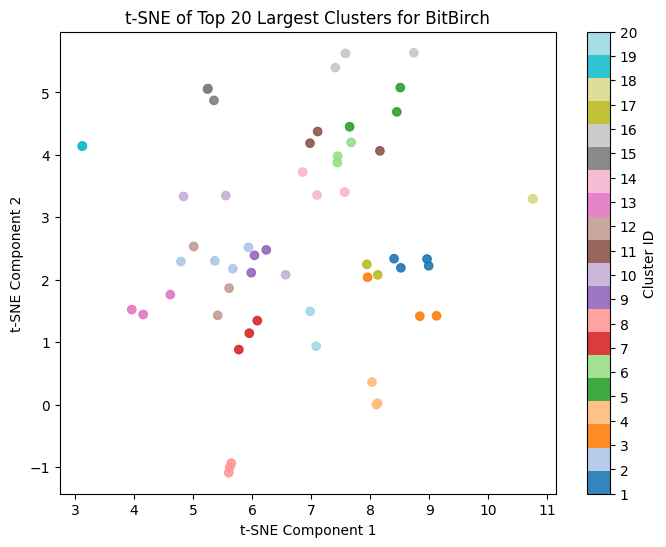

In [69]:
plotting_utils.tsne_plot(brc, feats, title="BitBirch")

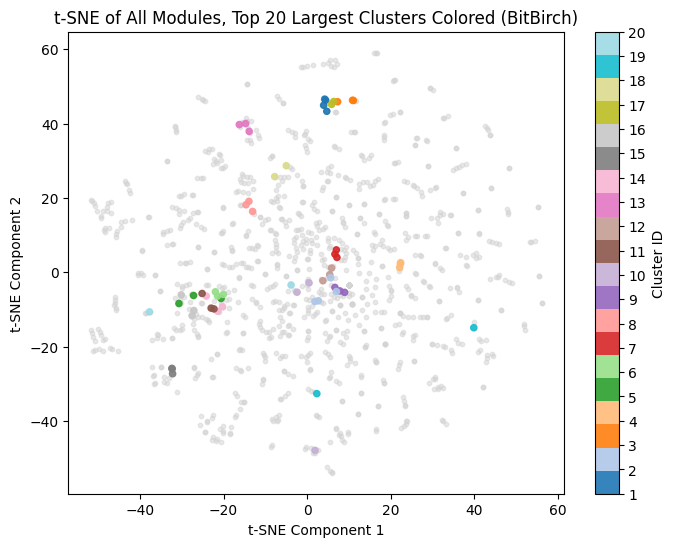

In [130]:
def plot_bitbirch_clusters(brc, feats):
    clusters = brc.get_cluster_mol_ids()
    # Find indices of all points in the top 20 largest clusters
    sort_clusters = sorted(clusters, key=lambda x: len(x), reverse=True)[:20]

    highlight_indices = [idx for cluster in sort_clusters for idx in cluster]
    highlight_set = set(highlight_indices)

    # Prepare cluster labels for all points: -1 for not in top clusters, 0-19 for cluster index
    cluster_labels = np.full(feats.shape[0], -1)
    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            cluster_labels[idx] = cluster_id

    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(feats)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    feats_tsne = tsne.fit_transform(feats_scaled)

    plt.figure(figsize=(8, 6))
    # Plot all points in gray
    plt.scatter(feats_tsne[:, 0], feats_tsne[:, 1], c='lightgray', alpha=0.5, s=10, label='Other')

    # Plot highlighted clusters
    mask = cluster_labels != -1
    scatter = plt.scatter(
        feats_tsne[mask, 0], feats_tsne[mask, 1],
        c=cluster_labels[mask], cmap='tab20', alpha=0.9, s=20, label='Top 20 clusters'
    )
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))
    cbar.set_ticklabels(np.arange(1, 21))
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of All Modules, Top 20 Largest Clusters Colored (BitBirch)")

plot_bitbirch_clusters(brc, feats)

In [72]:
clustered_module_ids = dict()
for cluster_id, cluster in enumerate(brc.get_cluster_mol_ids()):
    clustered_module_ids[cluster_id] = list()
    for idx in cluster:
        clustered_module_ids[cluster_id].append(module_ids[idx])
clustered_module_ids

{0: ['M347', 'M394', 'M427', 'M597'],
 1: ['M932', 'M935', 'M936', 'M965'],
 2: ['M118', 'M541', 'M589'],
 3: ['M200', 'M41', 'M532'],
 4: ['M933', 'M938', 'M946'],
 5: ['M934', 'M974', 'M975'],
 6: ['M937', 'M941', 'M958'],
 7: ['M705', 'M713', 'M722'],
 8: ['M626', 'M631', 'M658'],
 9: ['M641', 'M650', 'M656'],
 10: ['M579', 'M599', 'M606'],
 11: ['M582', 'M586', 'M590'],
 12: ['M539', 'M558', 'M56'],
 13: ['M479', 'M503', 'M508'],
 14: ['M493', 'M505', 'M513'],
 15: ['M445', 'M453', 'M464'],
 16: ['M664', 'M964'],
 17: ['M983', 'M993'],
 18: ['M984', 'M985'],
 19: ['M942', 'M961'],
 20: ['M949', 'M952'],
 21: ['M954', 'M962'],
 22: ['M955', 'M967'],
 23: ['M915', 'M924'],
 24: ['M929', 'M930'],
 25: ['M858', 'M86'],
 26: ['M861', 'M883'],
 27: ['M82', 'M820'],
 28: ['M825', 'M837'],
 29: ['M836', 'M852'],
 30: ['M839', 'M84'],
 31: ['M793', 'M799'],
 32: ['M743', 'M76'],
 33: ['M747', 'M778'],
 34: ['M703', 'M726'],
 35: ['M71', 'M729'],
 36: ['M681', 'M682'],
 37: ['M624', 'M625'],

In [124]:
cluster_assignment = dict()
for cluster_id, cluster in clustered_module_ids.items():
    for module_id in cluster:
        cluster_assignment[module_id] = cluster_id
cluster_assignment

{'M347': 0,
 'M394': 0,
 'M427': 0,
 'M597': 0,
 'M932': 1,
 'M935': 1,
 'M936': 1,
 'M965': 1,
 'M118': 2,
 'M541': 2,
 'M589': 2,
 'M200': 3,
 'M41': 3,
 'M532': 3,
 'M933': 4,
 'M938': 4,
 'M946': 4,
 'M934': 5,
 'M974': 5,
 'M975': 5,
 'M937': 6,
 'M941': 6,
 'M958': 6,
 'M705': 7,
 'M713': 7,
 'M722': 7,
 'M626': 8,
 'M631': 8,
 'M658': 8,
 'M641': 9,
 'M650': 9,
 'M656': 9,
 'M579': 10,
 'M599': 10,
 'M606': 10,
 'M582': 11,
 'M586': 11,
 'M590': 11,
 'M539': 12,
 'M558': 12,
 'M56': 12,
 'M479': 13,
 'M503': 13,
 'M508': 13,
 'M493': 14,
 'M505': 14,
 'M513': 14,
 'M445': 15,
 'M453': 15,
 'M464': 15,
 'M664': 16,
 'M964': 16,
 'M983': 17,
 'M993': 17,
 'M984': 18,
 'M985': 18,
 'M942': 19,
 'M961': 19,
 'M949': 20,
 'M952': 20,
 'M954': 21,
 'M962': 21,
 'M955': 22,
 'M967': 22,
 'M915': 23,
 'M924': 23,
 'M929': 24,
 'M930': 24,
 'M858': 25,
 'M86': 25,
 'M861': 26,
 'M883': 26,
 'M82': 27,
 'M820': 27,
 'M825': 28,
 'M837': 28,
 'M836': 29,
 'M852': 29,
 'M839': 30,
 'M84': 3

# K-means

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [119]:
def run_kmeans(sparse_feature_matrix, k, cores):
    with parallel_backend("loky", n_jobs=cores):
        k_means = KMeans(
            n_clusters=k,
            n_init=20,
            max_iter=1000,
            random_state=595,
            verbose=0,
            tol=1e-6,
        ).fit(sparse_feature_matrix)
    return k_means


def plot_kmeans_clusters(k_means, sparse_feature_matrix):
    feats = binary_feature_matrix.toarray()
    k = k_means.n_clusters

    clusters = []
    for i in range(k):
        clusters.append([idx for idx, cluster_id in enumerate(k_means.labels_) if cluster_id == i])


    sort_clusters = sorted(clusters, key=lambda x: len(x), reverse=True)[:20]
    # #     # Map each mol ID to its cluster ID
    n_molecules = sum([len(x) for x in sort_clusters])


    cluster_labels = [0] * n_molecules

    fps_clusters = []#[0] * n_molecules
    cluster_labels = []#[0] * n_molecules

    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            fps_clusters.append(feats[idx])
            cluster_labels.append(int(cluster_id))


    scaler = StandardScaler()
    fps_scaled = scaler.fit_transform(fps_clusters)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    fps_tsne = tsne.fit_transform(fps_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(fps_tsne[:, 0], fps_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.9)
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))  # Set ticks at the center of each color
    cbar.set_ticklabels(np.arange(1, 21))  # Set labels from 1 to 20
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of Top 20 Largest Clusters for K-Means (k={k})")

In [127]:
def plot_kmeans_clusters(k_means, sparse_feature_matrix):
    feats = binary_feature_matrix.toarray()
    k = k_means.n_clusters

    # Find indices of all points in the top 20 largest clusters
    sort_clusters = sorted(
        [[idx for idx, cluster_id in enumerate(k_means.labels_) if cluster_id == i] for i in range(k)],
        key=lambda x: len(x), reverse=True
    )[:20]
    highlight_indices = [idx for cluster in sort_clusters for idx in cluster]
    highlight_set = set(highlight_indices)

    # Prepare cluster labels for all points: -1 for not in top clusters, 0-19 for cluster index
    cluster_labels = np.full(feats.shape[0], -1)
    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            cluster_labels[idx] = cluster_id

    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(feats)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    feats_tsne = tsne.fit_transform(feats_scaled)

    plt.figure(figsize=(8, 6))
    # Plot all points in gray
    plt.scatter(feats_tsne[:, 0], feats_tsne[:, 1], c='lightgray', alpha=0.5, s=10, label='Other')

    # Plot highlighted clusters
    mask = cluster_labels != -1
    scatter = plt.scatter(
        feats_tsne[mask, 0], feats_tsne[mask, 1],
        c=cluster_labels[mask], cmap='tab20', alpha=0.9, s=20, label='Top 20 clusters'
    )
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))
    cbar.set_ticklabels(np.arange(1, 21))
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of All Modules, Top 20 Largest Clusters Colored (k={k})")

In [115]:
k = 500
cores = 1
%time k_means = run_kmeans(sparse_feature_matrix, k, cores)
#k_clustered_modules = {mod_id: fam_id for mod_id, fam_id in zip(rownames, k_means.labels_)}

CPU times: user 44.7 s, sys: 1.15 s, total: 45.8 s
Wall time: 9.21 s


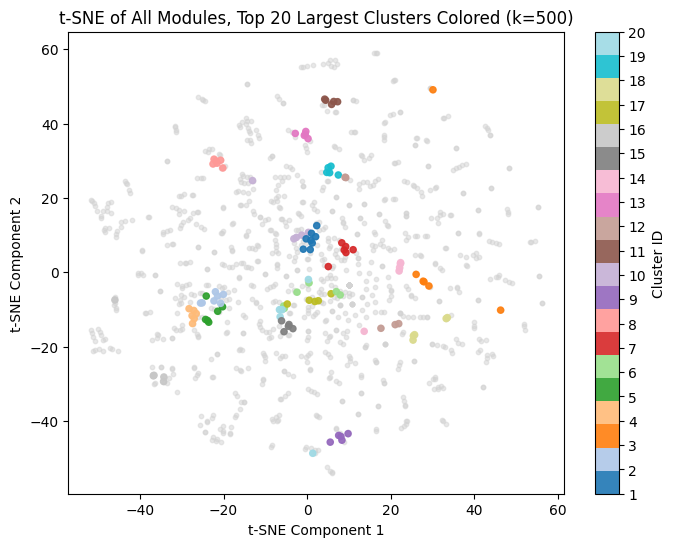

In [128]:
plot_kmeans_clusters(k_means, binary_feature_matrix)

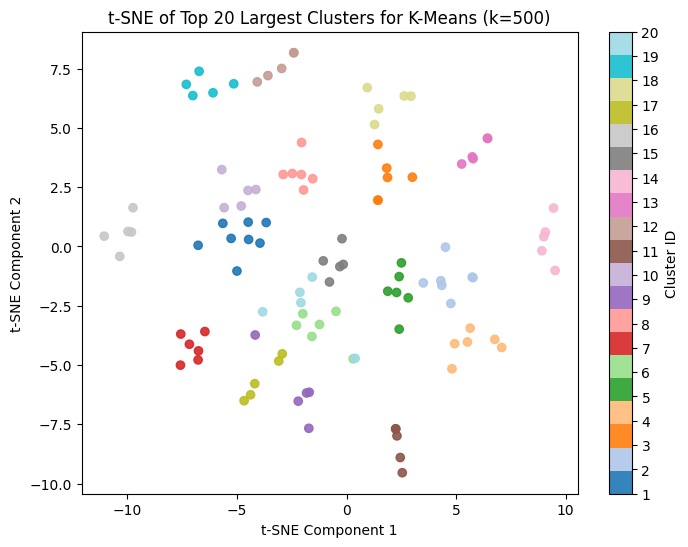

In [121]:
plot_kmeans_clusters(k_means, binary_feature_matrix)

In [96]:
# clusters = []
# for i in range(k):
#     clusters.append([mod for mod, fam in k_clustered_modules.items() if fam == i])
# clusters